In [1]:
import uproot
import pandas as pd

# Open root file
file = uproot.open("mc_110910.ZPrime3000.root")

# List available trees
print(file.keys())

tree = file["mini"] # Access the 'mini' tree
print(tree.keys()) # List all branches (columns)

# Convert ROOT tree to Pandas DataFrame
df = tree.arrays(library="pd")

print(df.head()) # Display first few rows

['mini;1']
['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'pvxp_n', 'vxp_z', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_BTAG', 'scaleFactor_TRIGGER', 'scaleFactor_JVFSF', 'scaleFactor_ZVERTEX', 'trigE', 'trigM', 'passGRL', 'hasGoodVertex', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_flag', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'alljet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_m', 'jet_jvf', 'jet_trueflav', 'jet_truthMatched', 'jet_SV0', 'jet_MV1']
   runNumber  eventNumber  channelNumber  mcWeight  pvxp_n       vxp_z  \
0     195847         5003         110910  1.000000       8   -1.826180   
1     195847         5013         110910  1.001217       9   19.877777   
2     195847         5035         110910  1.000000       7  105.884720   
3     195847         5036         11091

<b>---Anomaly Detection using Event-Based Variables---</b>

In [2]:
# Preprocessing Data
from sklearn.preprocessing import StandardScaler
"""
met_et → Missing transverse energy (MET)
met_phi → MET direction
lep_n → Number of leptons in the event
jet_n → Number of jets in the event
pvxp_n → Number of primary vertices
"""

event_features = ["met_et", "met_phi", "lep_n", "jet_n", "pvxp_n"]
df_events = df[event_features].dropna() # Remove missing values

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_events)

print("Preprocessed Data Shape:", df_scaled.shape)

Preprocessed Data Shape: (19634, 5)


In [3]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

#Train
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(df_scaled)

df_events["anomaly"] = model.predict(df_scaled) # Predict anomalies (-1 = anomaly, 1 = normal)
print(df_events["anomaly"].value_counts()) # Count anomalies

anomaly
 1    18652
-1      982
Name: count, dtype: int64


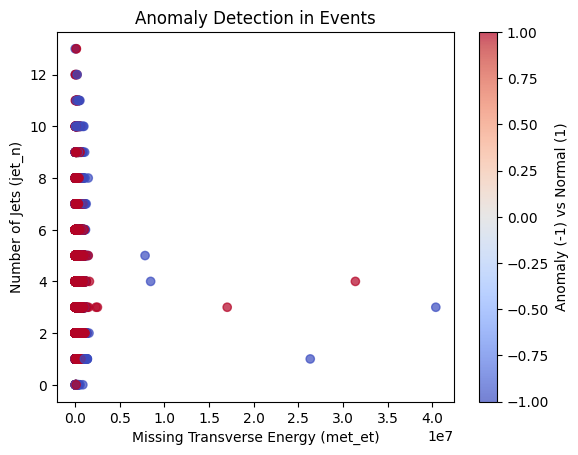

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df_events["met_et"], df_events["jet_n"], c=df_events["anomaly"], cmap="coolwarm", alpha=0.7)
plt.xlabel("Missing Transverse Energy (met_et)")
plt.ylabel("Number of Jets (jet_n)")
plt.title("Anomaly Detection in Events")
plt.colorbar(label="Anomaly (-1) vs Normal (1)")
plt.savefig("anomaly_visual1.png", dpi=300, bbox_inches='tight')
plt.show()

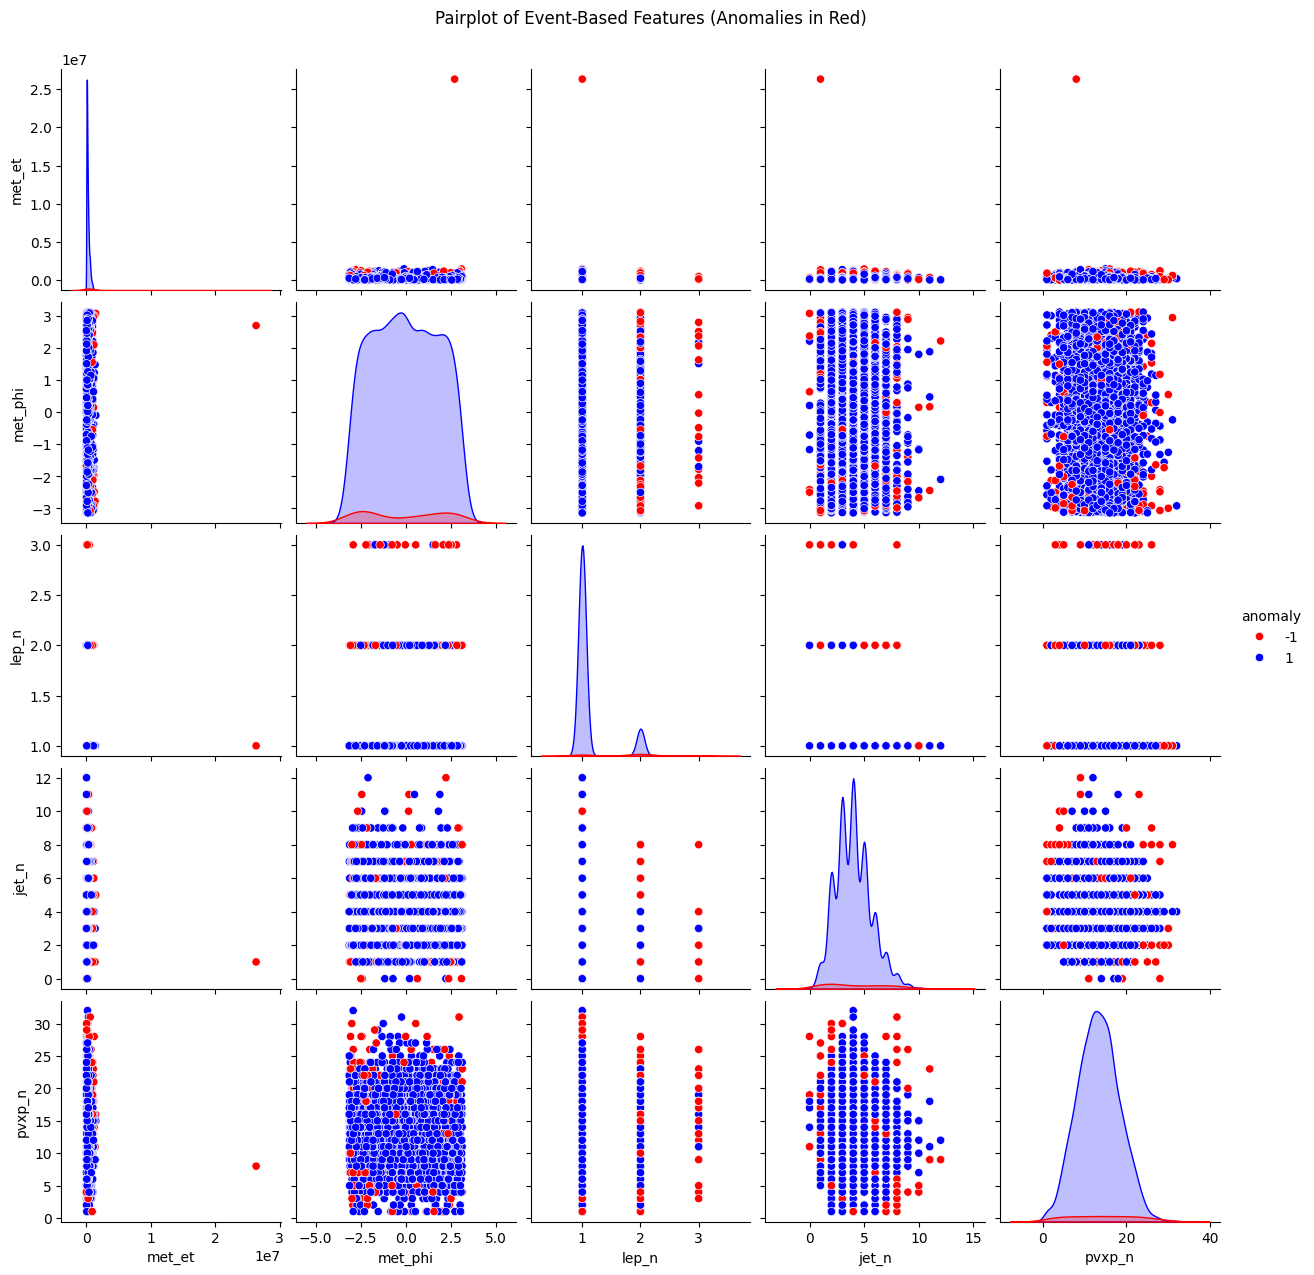

In [13]:
import seaborn as sns

# Sample only a subset for faster visualization
df_sample = df_events.sample(3000, random_state=42)

# Pairplot of event-based features
g = sns.pairplot(df_sample, hue="anomaly", palette={1: "blue", -1: "red"})
plt.suptitle("Pairplot of Event-Based Features (Anomalies in Red)", y=1.02)
g.fig.savefig("pairplot.png", dpi=300)  # ✅ Correct
plt.show()

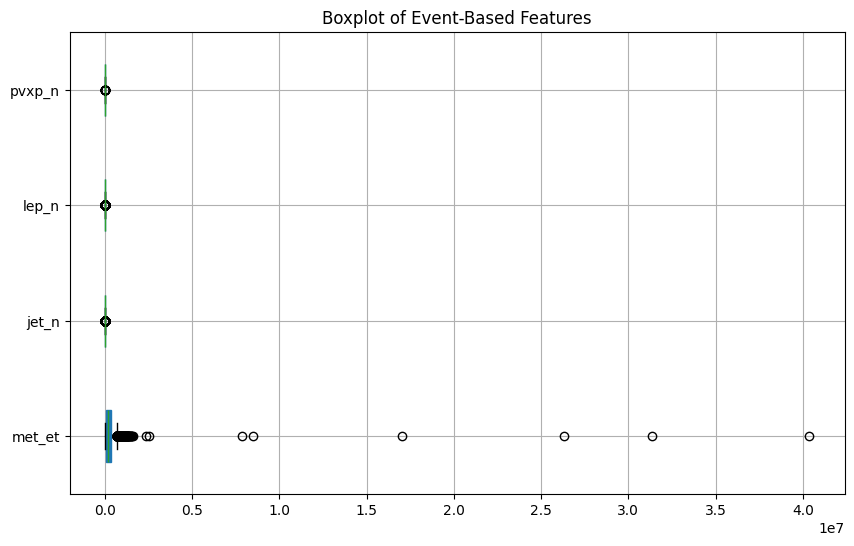

In [7]:
plt.figure(figsize=(10, 6))
df_events.boxplot(column=["met_et", "jet_n", "lep_n", "pvxp_n"], vert=False, patch_artist=True)
plt.title("Boxplot of Event-Based Features")
plt.savefig("boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

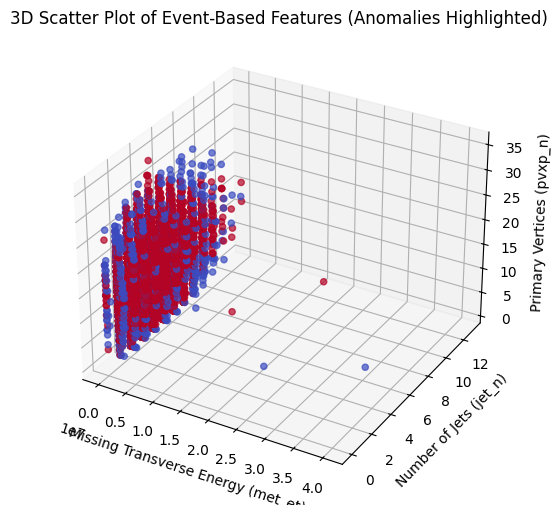

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot in 3D
ax.scatter(df_events["met_et"], df_events["jet_n"], df_events["pvxp_n"], 
           c=df_events["anomaly"], cmap="coolwarm", alpha=0.7)

ax.set_xlabel("Missing Transverse Energy (met_et)")
ax.set_ylabel("Number of Jets (jet_n)")
ax.set_zlabel("Primary Vertices (pvxp_n)")
ax.set_title("3D Scatter Plot of Event-Based Features (Anomalies Highlighted)")
plt.savefig("3dscatter.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Separate normal and anomalous events
normal_events = df_events[df_events["anomaly"] == 1]
anomalous_events = df_events[df_events["anomaly"] == -1]

# Compare the mean and standard deviation
comparison = normal_events.describe().T.join(anomalous_events.describe().T, lsuffix="_normal", rsuffix="_anomaly")
comparison[["mean_normal", "std_normal", "mean_anomaly", "std_anomaly"]]

,mean_normal,std_normal,mean_anomaly,std_anomaly
met_et,233143.343750,333101.281250,486372.406250,1.596347e+06
met_phi,-0.012799,1.790712,0.276258,2.114497e+00
lep_n,1.109157,0.315605,1.830957,6.090876e-01
jet_n,3.990832,1.620327,3.978615,2.774309e+00
pvxp_n,13.069912,5.023866,13.602851,7.966105e+00
anomaly,1.000000,0.000000,-1.000000,0.000000e+00


In [11]:
# Display a few anomalous events
print("Anomalous Events:")
display(anomalous_events.sample(5, random_state=42))

# Compare with normal events
print("Normal Events:")
display(normal_events.sample(5, random_state=42))

Anomalous Events:


,met_et,met_phi,lep_n,jet_n,pvxp_n,anomaly
17140,759628.125000,1.831004,2,4,15,-1
16848,777457.500000,-2.291067,1,1,23,-1
17886,225192.828125,-2.956639,1,12,15,-1
10099,315249.062500,0.924061,2,1,9,-1
1200,102042.796875,-2.288380,3,5,8,-1


Normal Events:


,met_et,met_phi,lep_n,jet_n,pvxp_n,anomaly
19362,192869.921875,1.517042,1,5,1,1
11698,61094.273438,1.199243,1,3,15,1
2289,245027.656250,0.117699,1,4,18,1
6905,556971.000000,-2.272463,1,4,12,1
5494,93339.656250,-1.649111,1,4,14,1


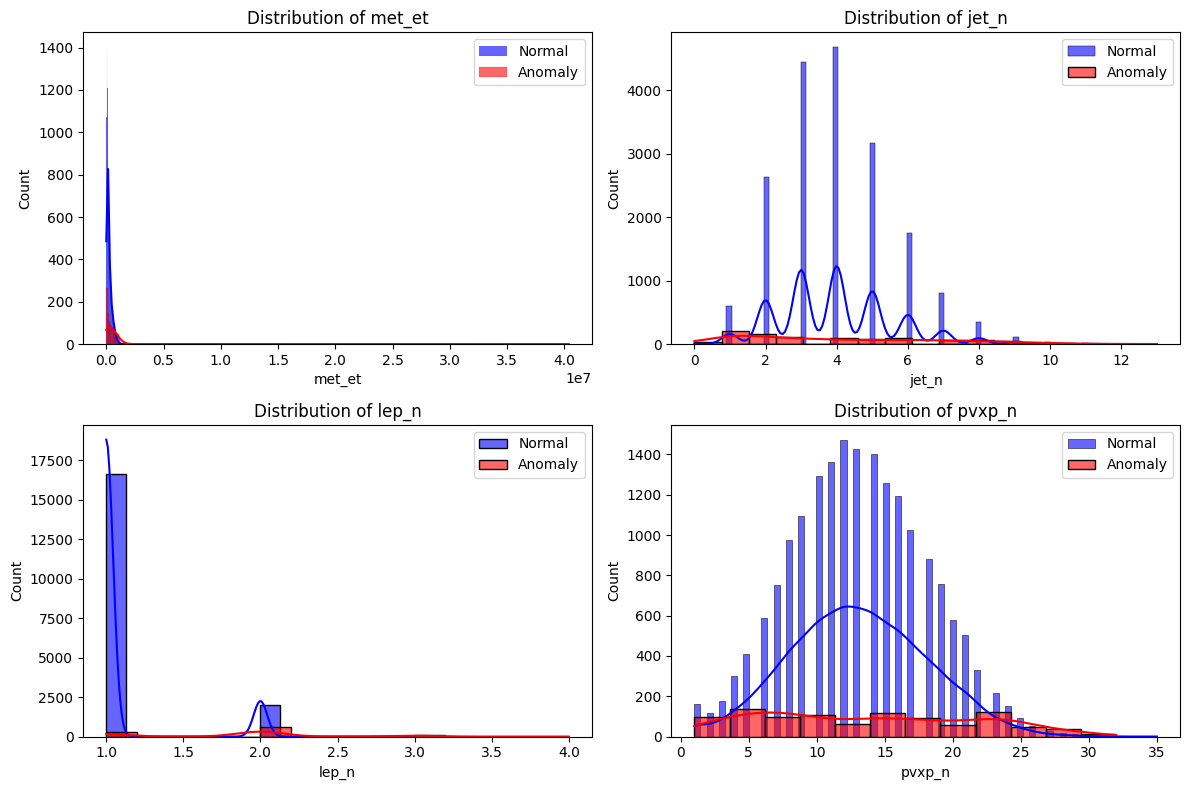

In [12]:
import seaborn as sns

features_to_plot = ["met_et", "jet_n", "lep_n", "pvxp_n"]
plt.figure(figsize=(12, 8))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(normal_events[feature], color="blue", kde=True, label="Normal", alpha=0.6)
    sns.histplot(anomalous_events[feature], color="red", kde=True, label="Anomaly", alpha=0.6)
    plt.title(f"Distribution of {feature}")
    plt.legend()

plt.tight_layout()
plt.savefig("distributions.png", dpi=300, bbox_inches='tight')
plt.show()